In [75]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
from tqdm.notebook import tqdm
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [3]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))
    
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)    

In [4]:
def avail_actions(s):
    string_array = np.array(list(s))
    return np.where(string_array == '1')[0]

def not_avail_actions(s):
    string_array = np.array(list(s))
    return np.where(string_array != '1')[0]

def play(env, Q, print_board=False, random_X=False, random_0=False):
    env.reset()
    s, empty_spaces, turn = env.getState()
    done = False
    pX=1
    p0=-1
    player = pX
    while not done:
        if player == pX and random_X or player == p0 and random_0:
            action = random.choice(avail_actions(s))
        else:
            action = np.argmax(Q[s])
        a = env.action_from_int(action)
        (s, empty_spaces, turn), reward, done, _ = env.step(a)
        if print_board:
            plot_board(env, None)
            #env.printBoard()
        player = - player
                    
    if reward == 1:
        return (1, 0)
    elif reward == -1:
        return (0, 1)
    else:
        return (0, 0)

def evaluate(env, Q, n=1000, disable_tqdm=False, random_X=False, random_0=False):
    rewardsX = []
    rewards0 = []
    for _ in tqdm(range(n), disable=disable_tqdm):
        rewardX, reward0 = play(env, Q, print_board=False, random_X=random_X, random_0=random_0)
        rewardsX.append(rewardX)
        rewards0.append(reward0)
    rX = np.mean(rewardsX)
    r0 = np.mean(rewards0)
    draw = 1 - rX - r0
    return rX, r0, draw

class Agent:
    def __init__(self, alpha, gamma, s=None, a=None):
        self.state = s
        self.action = a
        self.alpha = alpha
        self.gamma = gamma
        
    def update_Q(self, Q, state, action, reward):
        Q[self.state][self.action] = Q[self.state][self.action] + \
                                     self.alpha * (reward + self.gamma * np.max(Q[state]) - Q[self.state][self.action])
        self.state = state
        self.action = action
        
def Q_learning_episode(env, Q, A, alpha=0.05, epsilon=0.1, gamma=1):
    env.reset()
    s, empty_spaces, turn = env.getState()    
    agents = (
        Agent(alpha=alpha, gamma=gamma), 
        Agent(alpha=alpha, gamma=gamma)
    )
    done = False
    agent_idx = 0
    
    while not done:
        Q[s][not_avail_actions(s)] = -9999
        a = np.argmax(Q[s]) if random.random() < (1 - epsilon) else random.choice(avail_actions(s))
        agent = agents[agent_idx]
        agent.update_Q(Q, s, a, 0)
        agent_idx = 1 - agent_idx 
        (s, empty_spaces, turn), r , done, _ = env.step(env.action_from_int(a))    

    if r == -10:
        agent.update_Q(Q, s, a, r)
    else:
        agents[0].update_Q(Q, s, a, r) 
        agents[1].update_Q(Q, s, a, -r) 
        
    return Q

def Q_learning(env, Q, A, episodes=100_000, alpha=0.05, evaluate_every=1000, epsilon=0.3, gamma=1, disable_tqdm=False):
    hist_X = []
    hist_0 = []
    iters = []

    for i in tqdm(range(episodes), disable=disable_tqdm):
        Q = Q_learning_episode(env=env, Q=Q, A=A, alpha=alpha, epsilon=epsilon, gamma=gamma)
        if i % evaluate_every == 0:
            res_X = evaluate(env, Q, n=100, disable_tqdm=True, random_X=False, random_0=True)[0]
            res_0 = evaluate(env, Q, n=100, disable_tqdm=True, random_X=True, random_0=False)[1]
            hist_X.append(res_X)
            hist_0.append(res_0)
            iters.append(i)
            
    return Q, (hist_X, hist_0), iters


In [5]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
game_hash, empty_spaces, _ = env.getState()
A = tuple(range(len(empty_spaces)))
Q = defaultdict(lambda: np.zeros(len(A)))

In [6]:
Q, (hist_X, hist_0), iters = Q_learning(env, Q, A, episodes=200000, alpha=0.9, epsilon=0.5)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [02:59<00:00, 1113.53it/s]


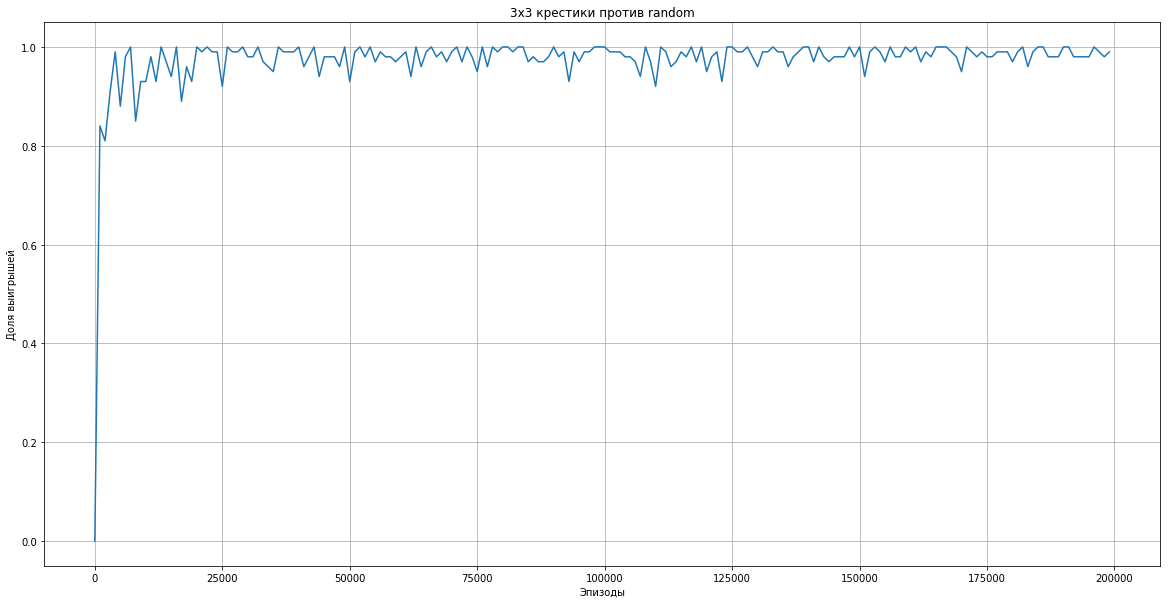

In [7]:
plt.figure(figsize=(20, 10))
plt.title('3x3 крестики против random')
plt.xlabel('Эпизоды')
plt.ylabel('Доля выигрышей')
plt.grid(True)
plt.plot(iters, hist_X);

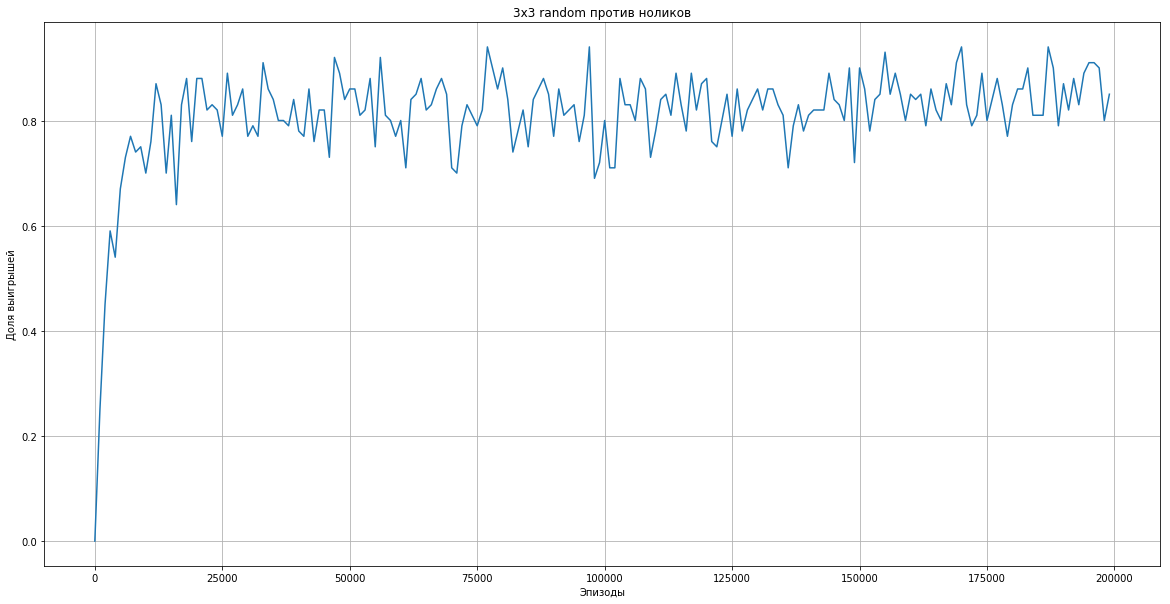

In [8]:
plt.figure(figsize=(20, 10))
plt.title('3x3 random против ноликов')
plt.xlabel('Эпизоды')
plt.ylabel('Доля выигрышей')
plt.grid(True)
plt.plot(iters, hist_0);

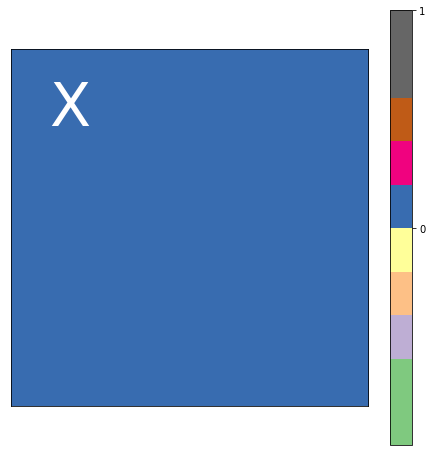

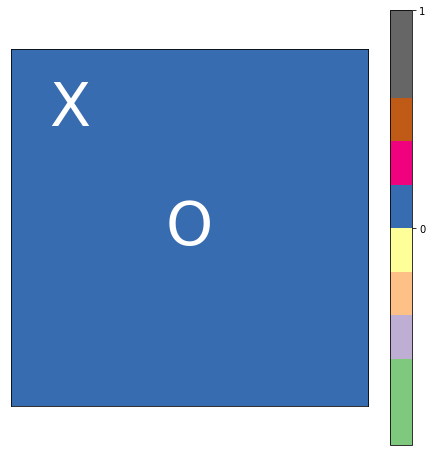

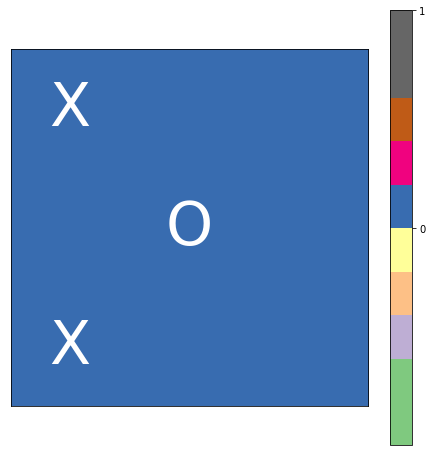

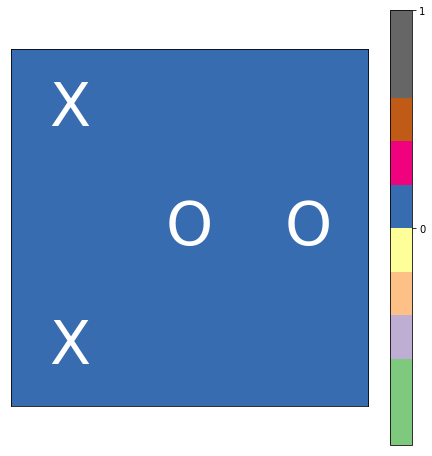

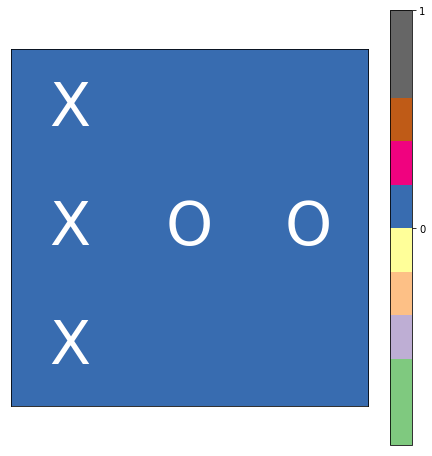

(1, 0)

In [9]:
play(env, Q, print_board=True, random_X=False, random_0=False)

In [10]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
game_hash, empty_spaces, _ = env.getState()
A = tuple(range(len(empty_spaces)))
Q = defaultdict(lambda: np.zeros(len(A)))

In [11]:
Q, (hist_X, hist_0), iters = Q_learning(env, Q, A, episodes=2000000, alpha=0.9, epsilon=0.5)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000000/2000000 [1:09:12<00:00, 481.69it/s]


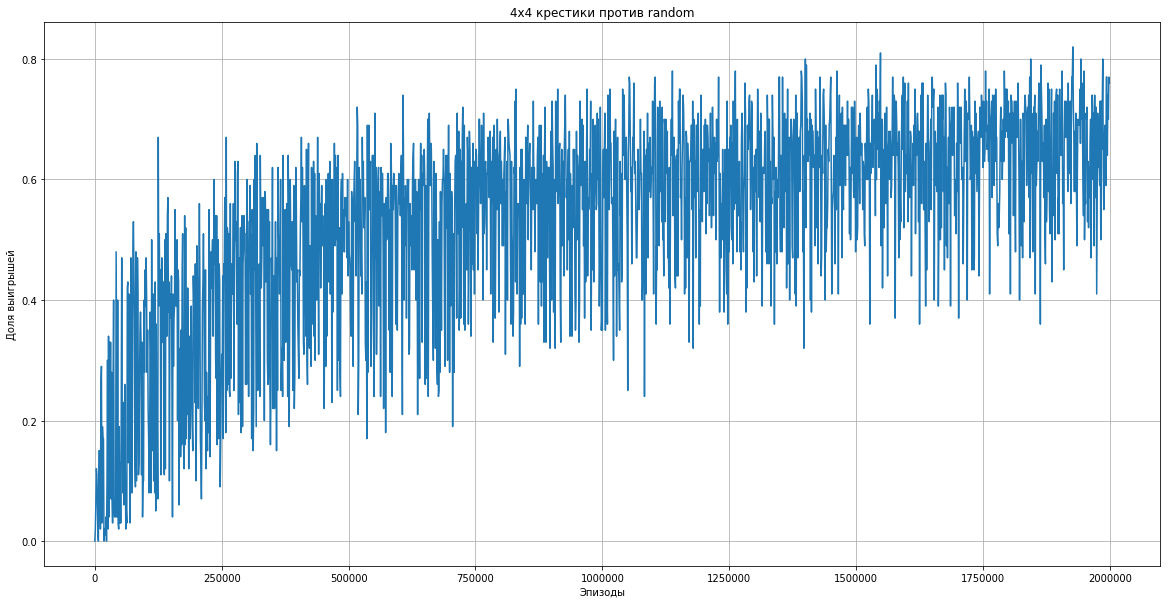

In [12]:
plt.figure(figsize=(20, 10))
plt.title('4x4 крестики против random')
plt.xlabel('Эпизоды')
plt.ylabel('Доля выигрышей')
plt.grid(True)
plt.plot(iters, hist_X);

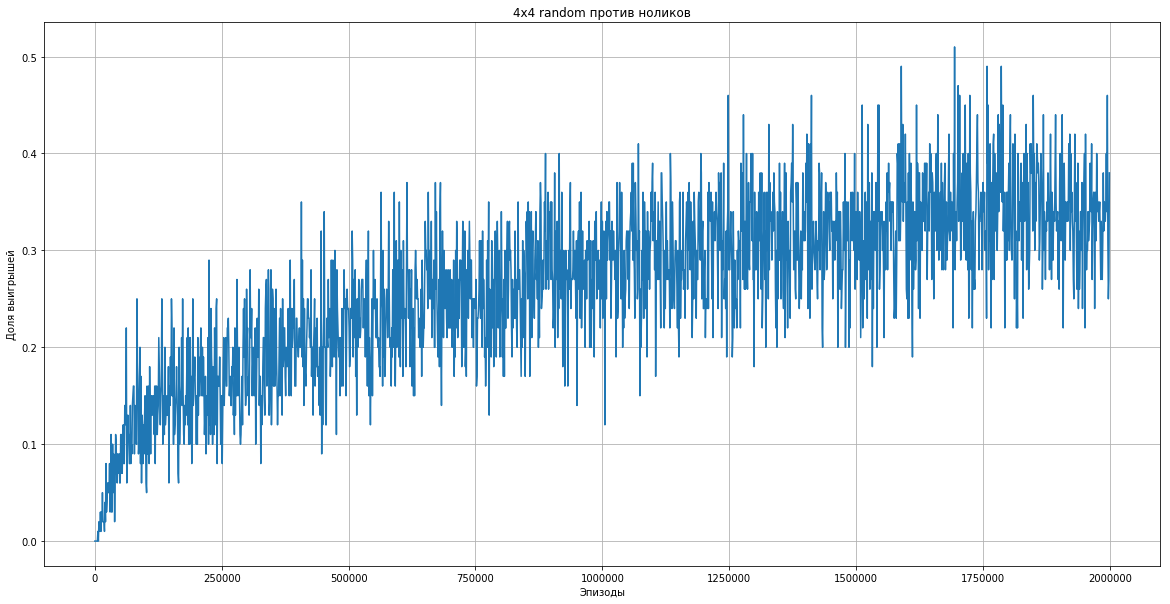

In [13]:
plt.figure(figsize=(20, 10))
plt.title('4x4 random против ноликов')
plt.xlabel('Эпизоды')
plt.ylabel('Доля выигрышей')
plt.grid(True)
plt.plot(iters, hist_0);

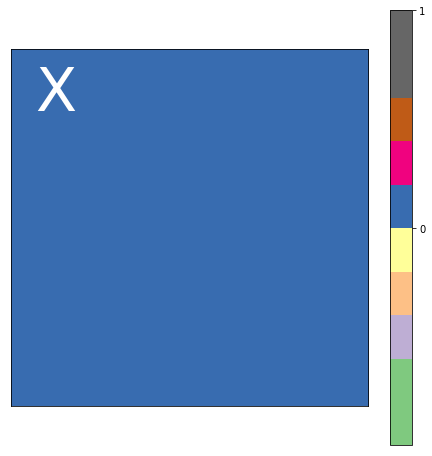

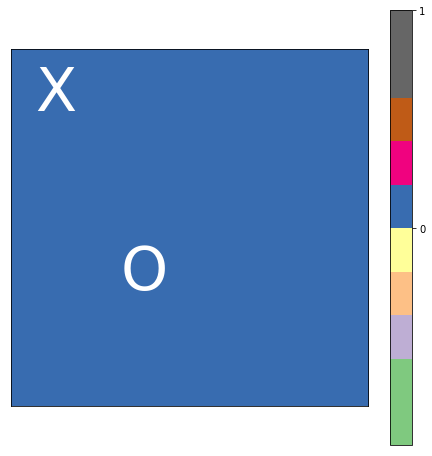

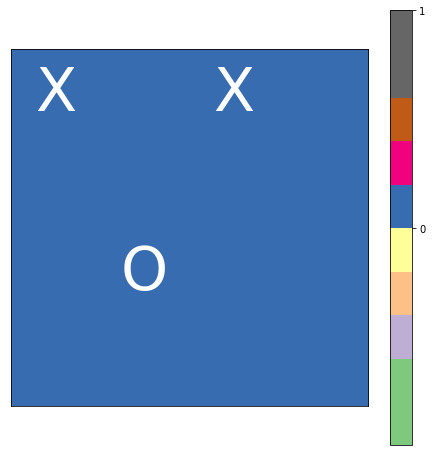

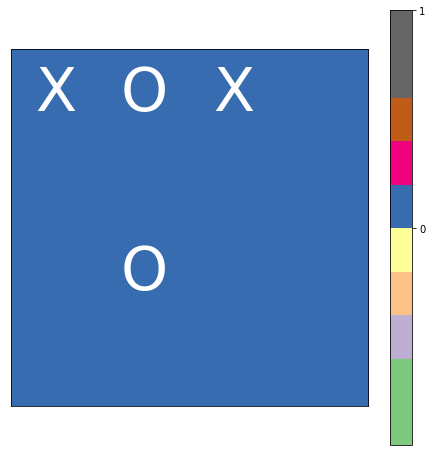

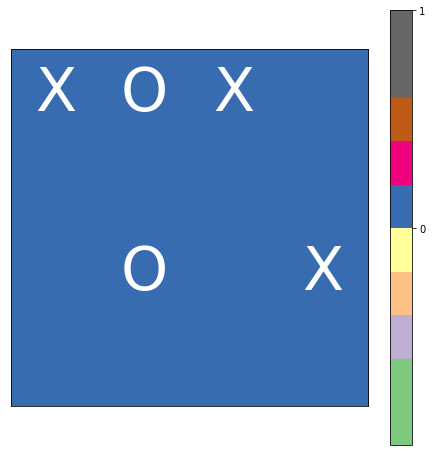

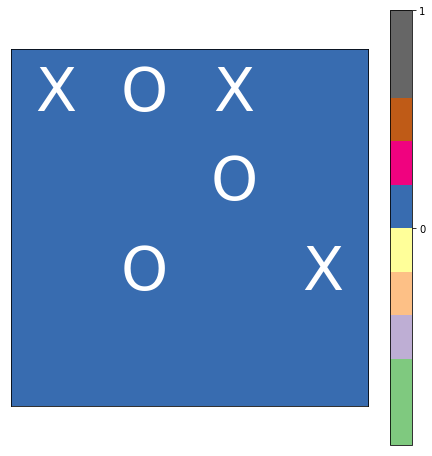

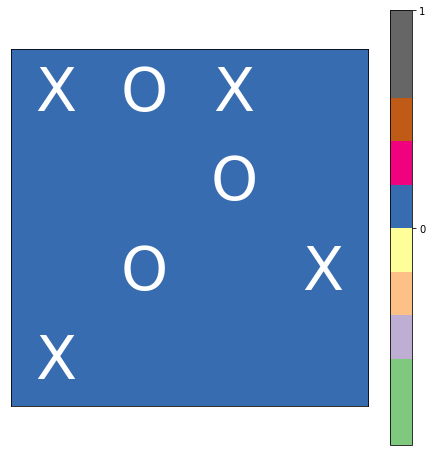

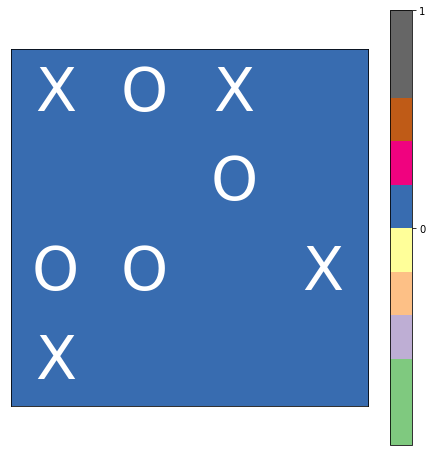

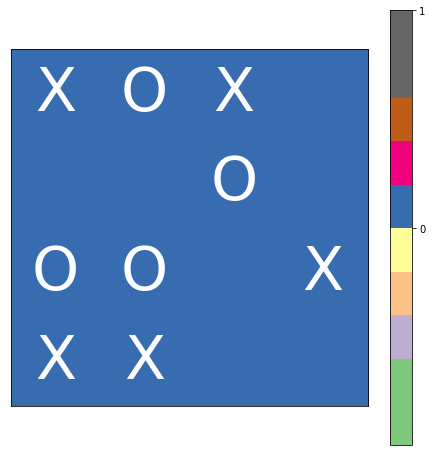

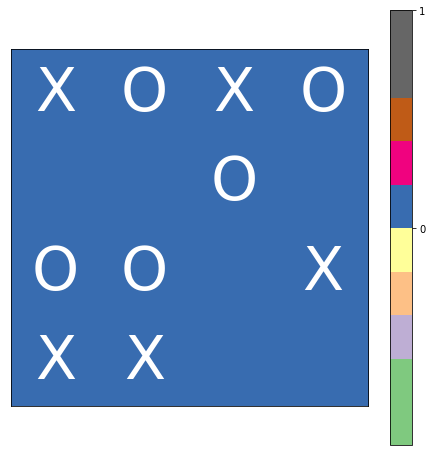

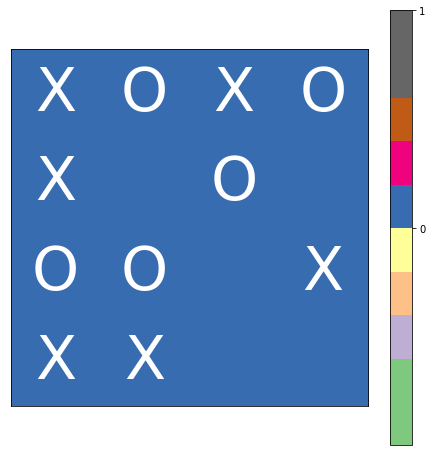

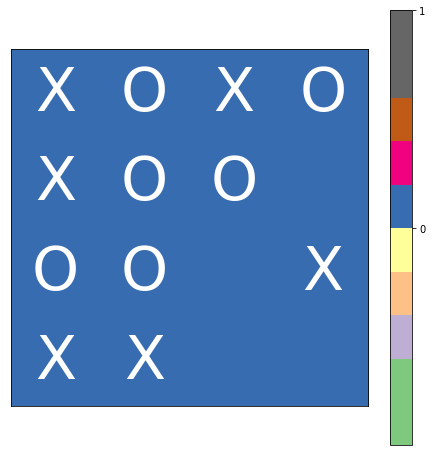

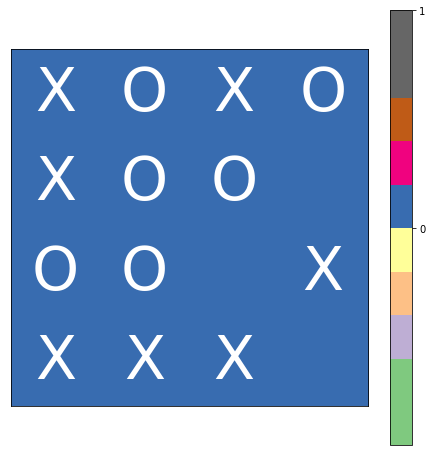

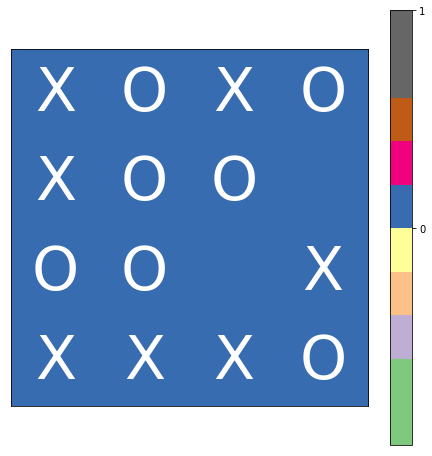

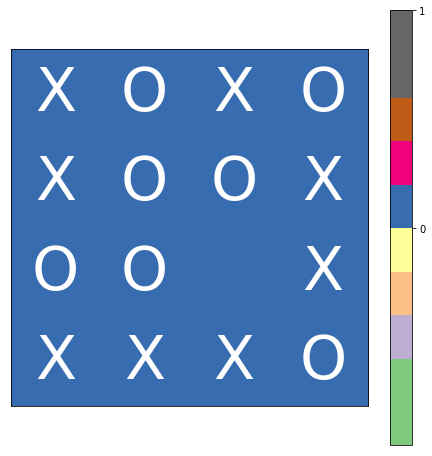

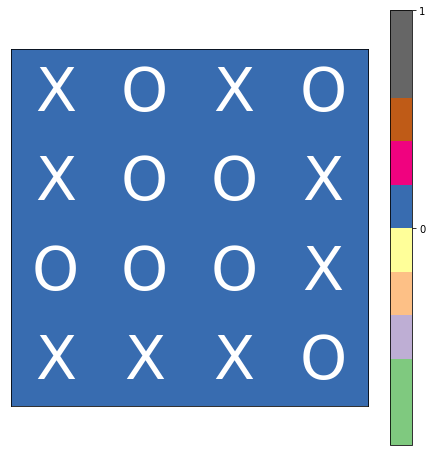

(0, 0)

In [14]:
play(env, Q, print_board=True, random_X=False, random_0=False)

In [56]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

class Player:
    def __init__(self, memory_capacity=10000):
        self.state = None
        self.action = None
        self.reward = None
        self.next_state = None
        self.memory = ReplayMemory(capacity=memory_capacity)
    
    def add_exp(self, next_state, action, reward):
        
        next_state = state_to_layers(next_state)
        if self.state is not None:
            self.memory.store((self.state, next_state, self.action, reward))
        self.state = next_state
        self.action = action
        
    def new_game(self):
        self.state = None
        self.action = None        

        
def state_to_layers(state):
    return np.array([
        (state == 1).astype(float), 
        (state == -1).astype(float), 
        (state == 0).astype(float)
    ])
        
def get_action_from_model(model, state):
    model.eval()
    state = state_to_layers(state)
    state = torch.FloatTensor([state])
    action = model(state).detach().max(1)[1][0].item()
    return action

def avail_actions(s):
    string_array = np.array(list(s))
    return np.where(string_array == '1')[0]
    
def get_action(model, state, game_hash, epsilon):
    if random.random() < (1 - epsilon):
        action = get_action_from_model(model, state)
    else:
        action = random.choice(avail_actions(game_hash))
    return action
        
def play_game_model(env, model, print_board=False, player1_random=False, player2_random=False):
    env.reset()
    game_hash, empty_spaces, turn = env.getState()
    state = env.board
    done = False
    result = [0, 0]
    player = 1
    while not done:
        
        if player == 1 and player1_random or player == -1 and player2_random:
            action = random.choice(avail_actions(game_hash))
        else:
            action =  get_action_from_model(model, state)
        action_tuple = env.action_from_int(action)
        (game_hash, empty_spaces, turn), reward, done, _ = env.step(action_tuple)
        state = env.board

        if print_board:
            plot_board(env, None)
            
        player = -player
                    
    if reward == 1:
        return (1, 0)
    elif reward == -1:
        return (0, 1)
    else:
        return (0, 0)
        
def evaluate_model(env, model, n=1000, disable_tqdm=False, player1_random=False, player2_random=False):
    model.eval()
    rewards1 = []
    rewards2 = []
    for _ in tqdm(range(n), disable=disable_tqdm):
        reward1, reward2 = play_game_model(
            env, 
            model, 
            print_board=False, 
            player1_random=player1_random, 
            player2_random=player2_random
        )
        rewards1.append(reward1)
        rewards2.append(reward2)
    r1 = np.mean(rewards1)
    r2 = np.mean(rewards2)
    no_winner = 1 - r1 - r2
    return r1, r2, no_winner

def train_batch(model, optimizer, criterion, replay_memory, batch_size=128, gamma=1):
    
    if len(replay_memory) < batch_size:
        return
    
    
    states, next_states, actions, rewards = list(zip(*replay_memory.sample(batch_size)))
    
    
    batch_state = torch.FloatTensor(states)
    batch_next_state = torch.FloatTensor(next_states)
    batch_actions = torch.LongTensor(actions)
    batch_reward = torch.FloatTensor(rewards) / 11.
    
    model.train()
    Q = model(batch_state).gather(1, batch_actions.view(-1, 1)).flatten()
    Qmax = model(batch_next_state).detach().max(dim=1)[0]
    Qnext = batch_reward + (gamma * Qmax)
    
    loss = criterion(Q, Qnext)

    
    loss.backward()
#     torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()


def play_episode(env, model1, model2, epsilon, player1, player2):
    env.reset()
    model1.eval()
    model2.eval()
    game_hash, empty_spaces, turn = env.getState()
    state = env.board.copy()
    done = False
    player1.new_game()
    player2.new_game()
    players = (player1, player2)
    models = (model1, model2)
    player_idx = 0
    
    while not done:
        player = players[player_idx]
        model = models[player_idx]
        action = get_action(model, state, game_hash, epsilon)
        player.add_exp(state, action, 0)
        player_idx = 1 - player_idx
        (game_hash, empty_spaces, turn), reward , done, _ = env.step(env.action_from_int(action))
        state = env.board.copy()
        
    if reward == -10:
        player.add_exp(state, action, reward)
    else:
        players[0].add_exp(state, action, reward)
        players[1].add_exp(state, action, -reward)
        

def run_learning(env, model1_tuple, model2_tuple, criterion, episodes=10000, eps_init=0.5, batch_size=64, gamma=1, model_name='dqn'):
    p1, p2 = Player(), Player()
    model1, optimizer1, scheduler1 = model1_tuple
    model2, optimizer2, scheduler2 = model2_tuple
    
    loss_cache_p1 = []
    loss_cache_p2 = []
    hist_p1 = []
    hist_p2 = []
    iters = []
    loss_hist_p1 = []
    loss_hist_p2 = []
    best_result_p1 = 0
    best_result_p2 = 0
    pbar = tqdm(range(episodes))
    
    eps_final = 0.05
    eps_decay = int(episodes / 2)
    
    for i in pbar:
#         eps_threshold = eps_final + (eps_init - eps_final) * math.exp(-1. * i / eps_decay)
        eps_threshold = eps_init
        for _ in range(1):
            play_episode(env, model1, model2, eps_threshold, p1, p2)
        
        loss1 = train_batch(model1, optimizer1, criterion, p1.memory, batch_size=batch_size, gamma=gamma)
        loss2 = train_batch(model2, optimizer2, criterion, p2.memory, batch_size=batch_size, gamma=gamma)
        if loss1 is not None:
            loss_cache_p1.append(loss1)
        if loss2 is not None:
            loss_cache_p2.append(loss2)
        
        if (i + 1) % 100 == 0:
            result_p1, _, _ = evaluate_model(env, model1, n=200, player1_random=False, player2_random=True, disable_tqdm=True)
            _, result_p2, _ = evaluate_model(env, model2, n=200, player1_random=True, player2_random=False, disable_tqdm=True)
            
            iters.append(i)
            hist_p1.append(result_p1)
            hist_p2.append(result_p2)
            
            mean_loss_p1 = np.mean(loss_cache_p1) if loss_cache_p1 else 0
            loss_hist_p1.append(mean_loss_p1)
            
            mean_loss_p2 = np.mean(loss_cache_p2) if loss_cache_p2 else 0
            loss_hist_p2.append(mean_loss_p2)
            
            loss_cache_p1 = []
            loss_cache_p2 = []
            
            total_result = result_p1 + result_p2
            if scheduler1 is not None:
                scheduler1.step(mean_loss_p1)
            if scheduler2 is not None:
                scheduler2.step(mean_loss_p2)
            
            pbar.set_postfix({
                'l1': mean_loss_p1, 
                'l2': mean_loss_p2, 
                'p1': result_p1, 
                'p2': result_p2, 
#                 'total': total_result,
                'eps': eps_threshold,
            })

            if best_result_p1 < result_p1:
                torch.save(model1.state_dict(), f'best_{model_name}_p1.pth')
            if best_result_p2 < result_p2:
                torch.save(model2.state_dict(), f'best_{model_name}_p2.pth')
                
    return (hist_p1, hist_p2), (loss_hist_p1, loss_hist_p2), iters 

In [76]:
seed = 42
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
BCELoss = torch.nn.BCEWithLogitsLoss()

In [77]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)

In [78]:
class DQN_3x3(nn.Module):
    def __init__(self, hidden_size=512):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=hidden_size, kernel_size=(3, 3))
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 9)    
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = x.squeeze(-1).squeeze(-1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [79]:
model = DQN_3x3().eval()
x = torch.randn(128, 3, 3, 3)
model(x).shape

torch.Size([128, 9])

In [80]:
LR = 1e-6
WEIGHT_DECAY = 1e-9
HIDDEN_SIZE = 512
criterion = F.l1_loss

model1 = DQN_3x3(hidden_size=HIDDEN_SIZE)
#model1.to(device)
optimizer1 = optim.Adam(model1.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

model2 = DQN_3x3(hidden_size=HIDDEN_SIZE)
#model2.to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [81]:
(hist_p1, hist_p2), (loss_hist_p1, loss_hist_p2), iters = run_learning(
    env, 
    (model1, optimizer1, None), 
    (model2, optimizer2, None), 
    criterion,
    episodes=20000, 
    eps_init=0.5,
    batch_size=256,
    gamma=0.9 
)

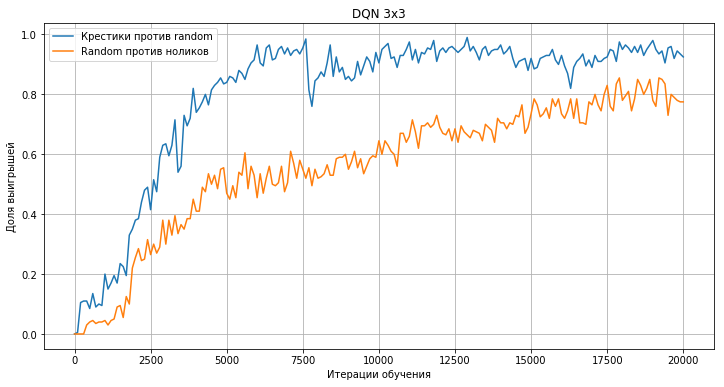

In [82]:
plt.figure(figsize=(12, 6))
plt.title('DQN 3x3')
plt.xlabel('Итерации обучения')
plt.ylabel('Доля выигрышей')
plt.grid(True)
plt.plot([0] + iters, [0] + hist_p1, label='Крестики против random')
plt.plot([0] + iters, [0] + hist_p2, label='Random против ноликов')
plt.legend();

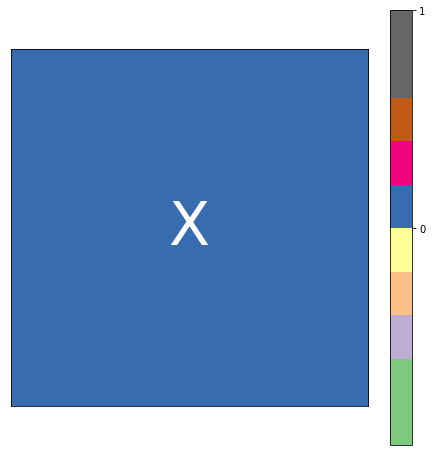

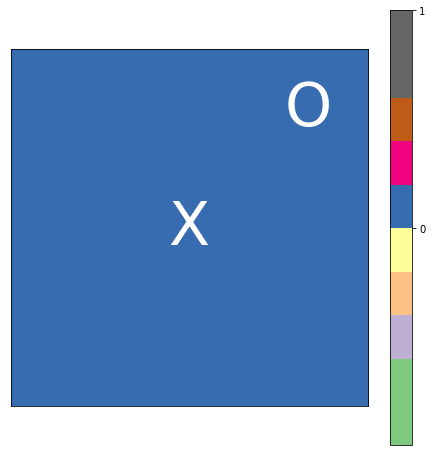

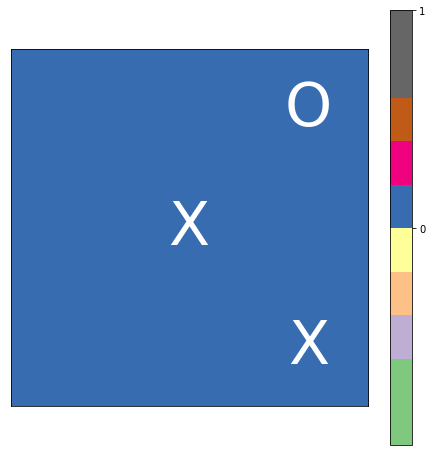

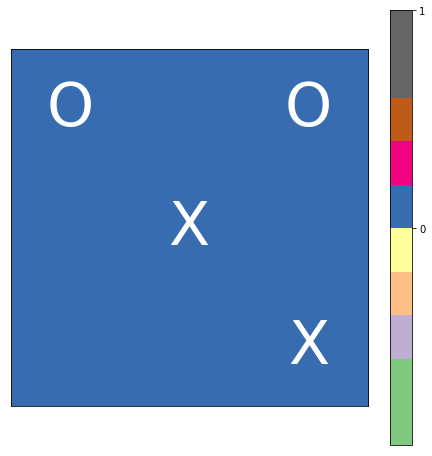

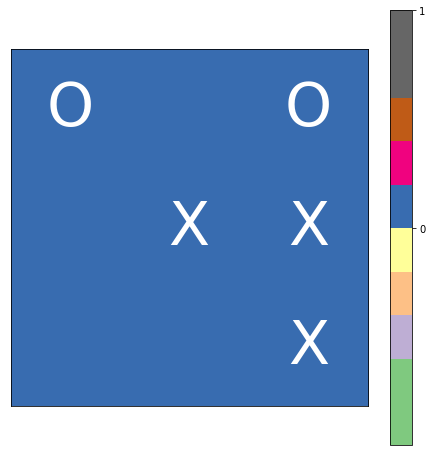

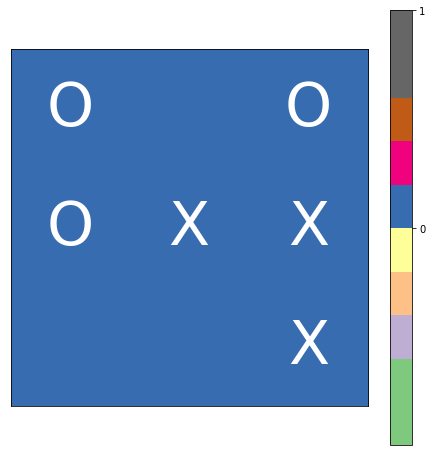

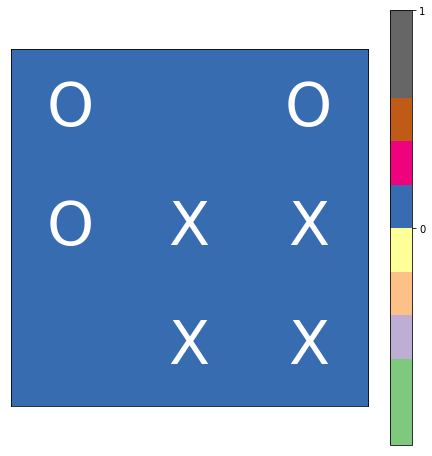

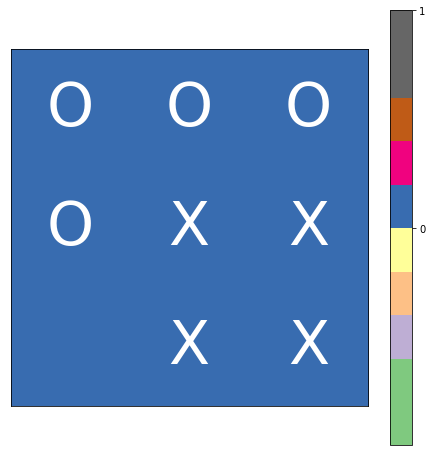

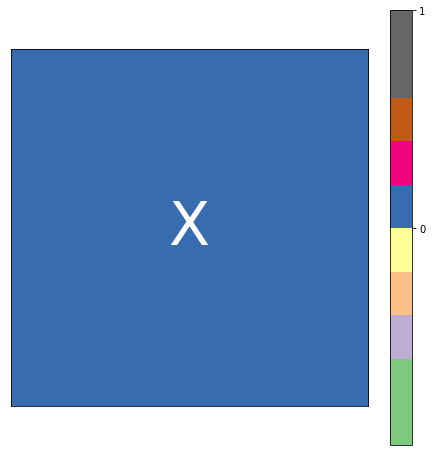

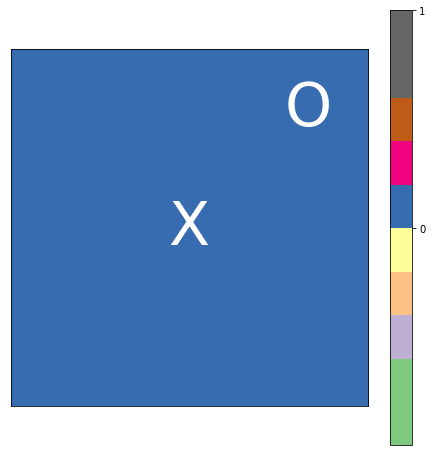

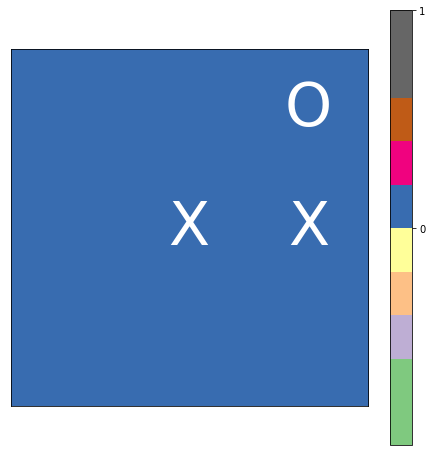

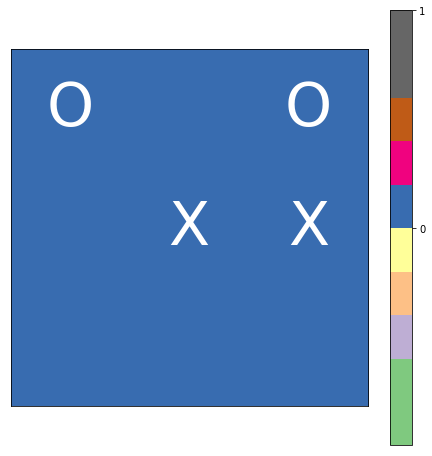

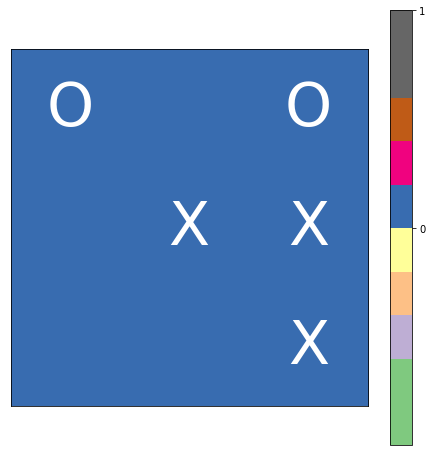

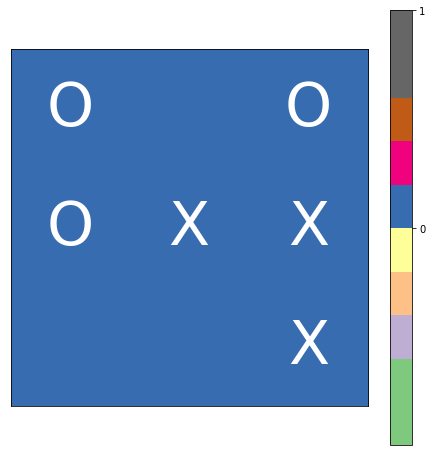

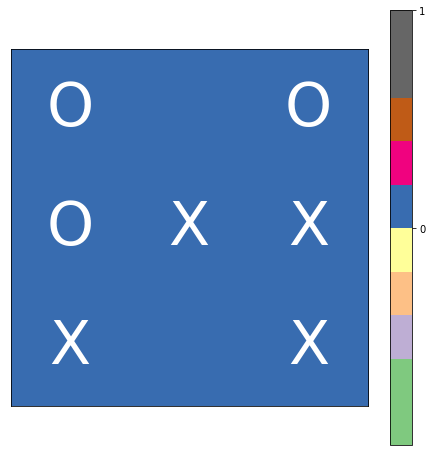

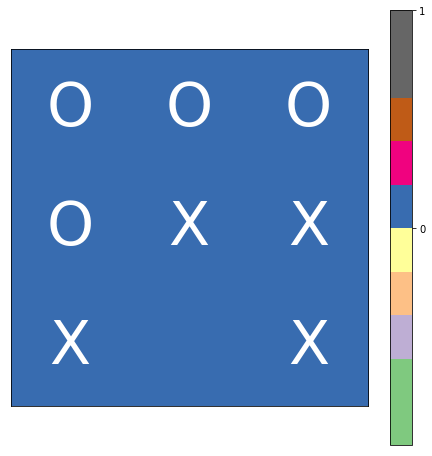

(0, 1)

In [83]:
play_game_model(env, model1, print_board=True, player1_random=False, player2_random=False)
play_game_model(env, model2, print_board=True, player1_random=False, player2_random=False)

In [84]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)

In [85]:
class DQN_4x4(nn.Module):
    def __init__(self, conv1_channels=32, conv2_channels=256):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=conv1_channels, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=(2, 2))
        self.fc1 = nn.Linear(conv2_channels, conv2_channels)
        self.fc2 = nn.Linear(conv2_channels, 16)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = x.squeeze(-1).squeeze(-1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x

In [86]:
LR = 1e-5
WEIGHT_DECAY = 1e-9
criterion = F.l1_loss

model1 = DQN_4x4()
optimizer1 = optim.Adam(model1.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

model2 = DQN_4x4()
optimizer2 = optim.Adam(model2.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [87]:
(hist_p1, hist_p2), (loss_hist_p1, loss_hist_p2), iters = run_learning(
    env, 
    (model1, optimizer1, None), 
    (model2, optimizer2, None), 
    criterion,
    episodes=20000, 
    eps_init=0.5,
    batch_size=256,
    gamma=0.9, 
)

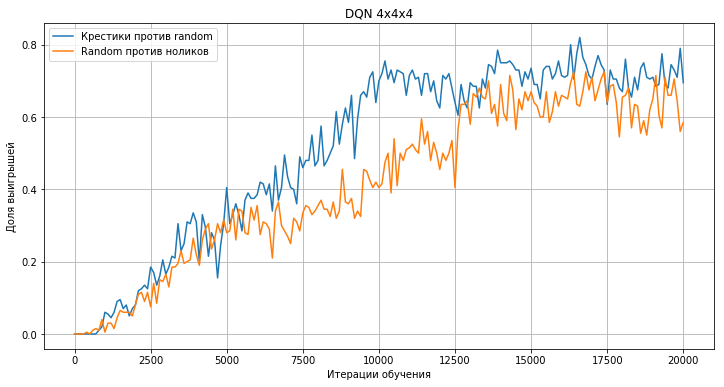

In [88]:
plt.figure(figsize=(12, 6))
plt.title('DQN 4x4x4')
plt.xlabel('Итерации обучения')
plt.ylabel('Доля выигрышей')
plt.grid(True)
plt.plot([0] + iters, [0] + hist_p1, label='Крестики против random')
plt.plot([0] + iters, [0] + hist_p2, label='Random против ноликов')
plt.legend();

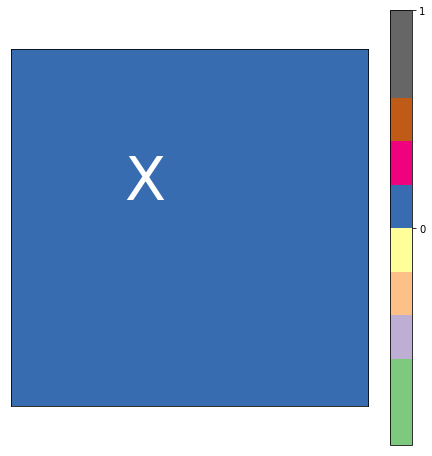

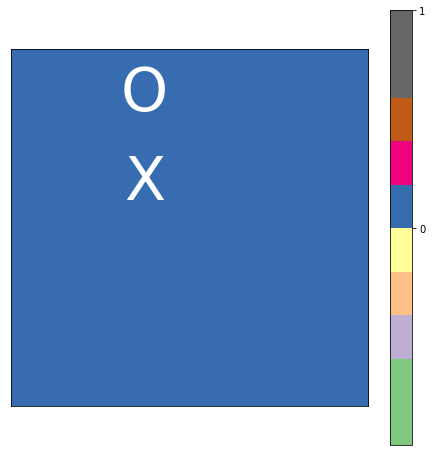

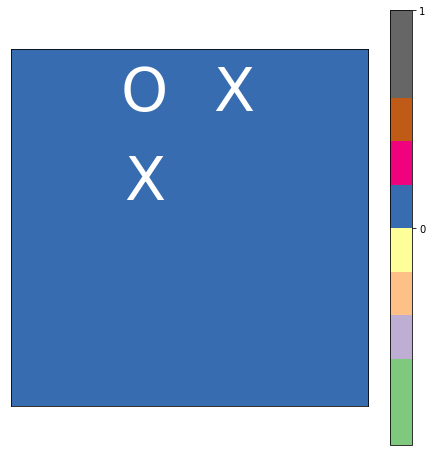

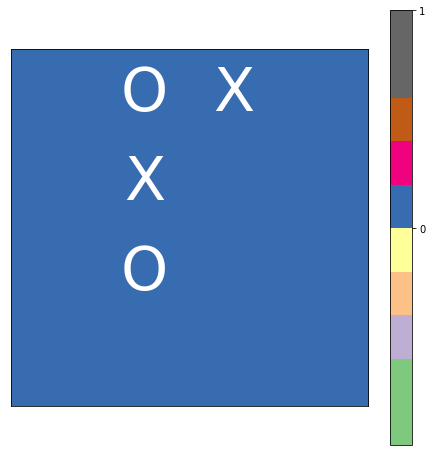

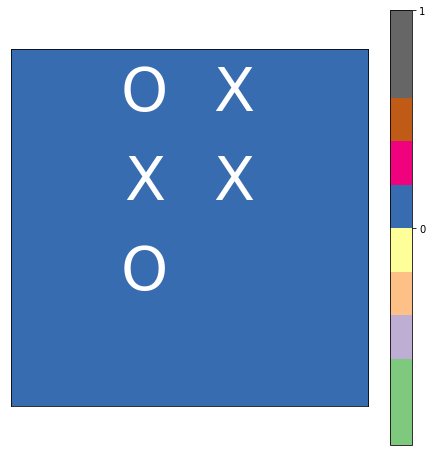

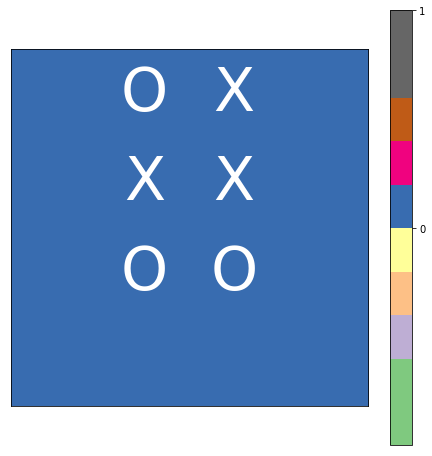

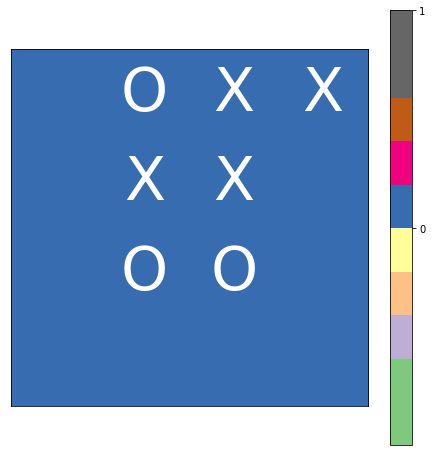

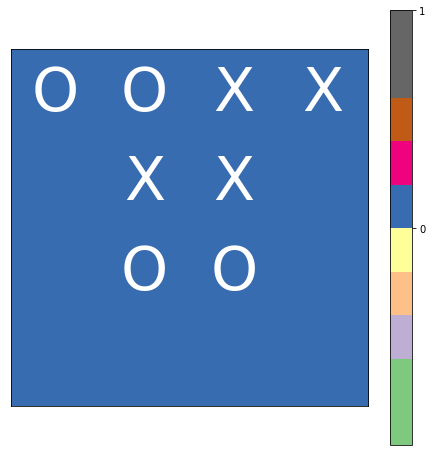

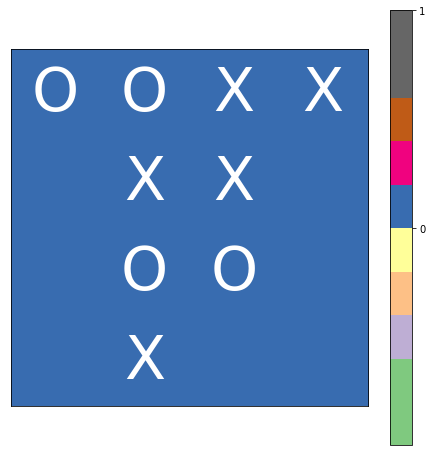

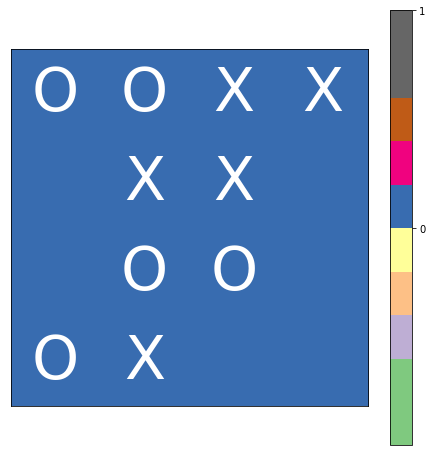

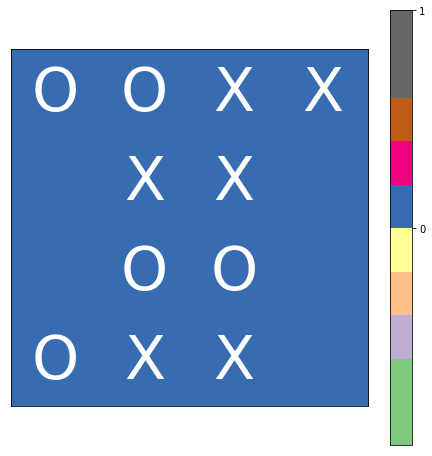

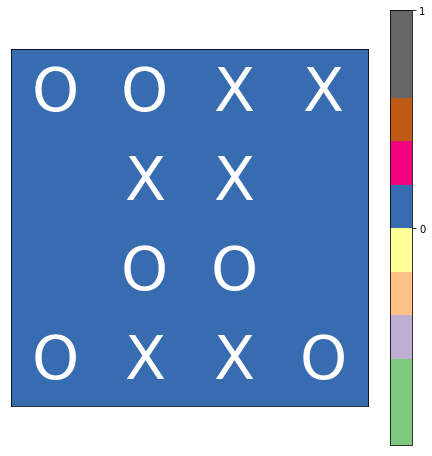

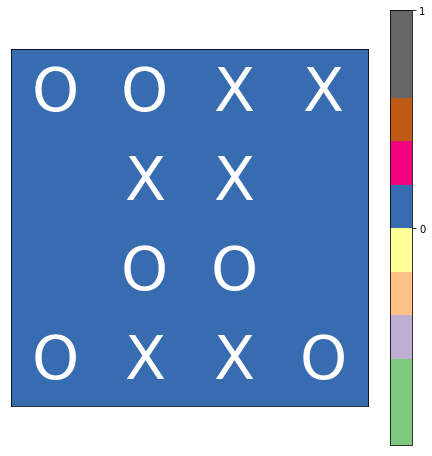

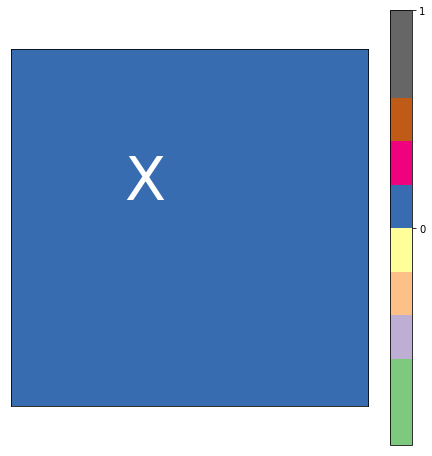

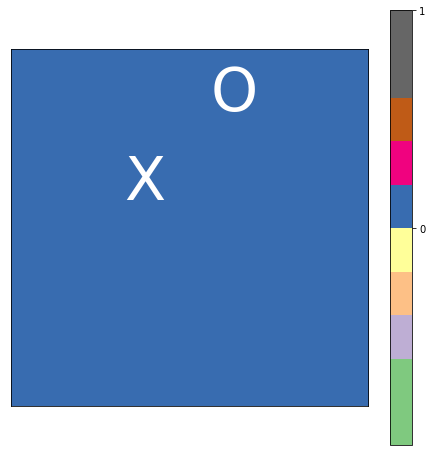

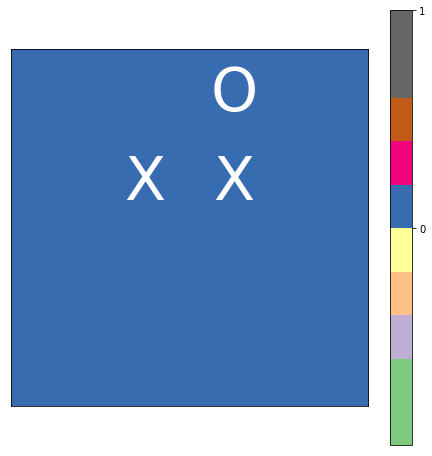

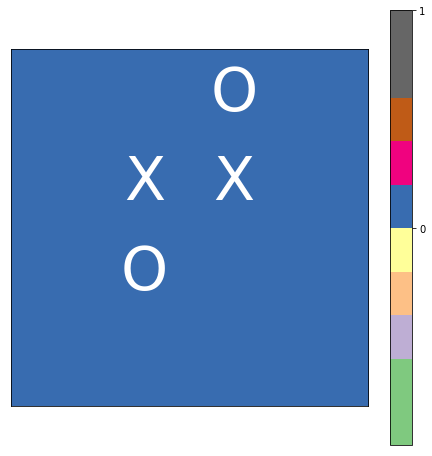

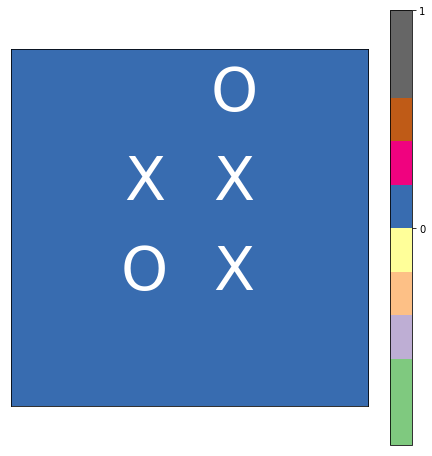

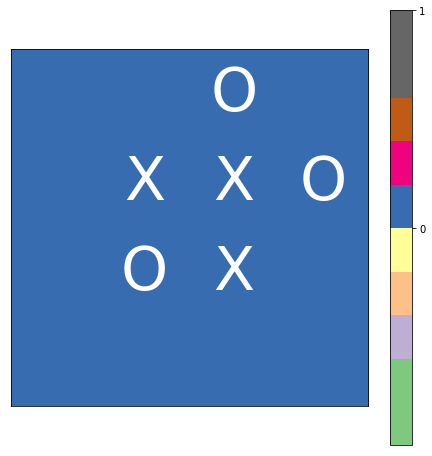

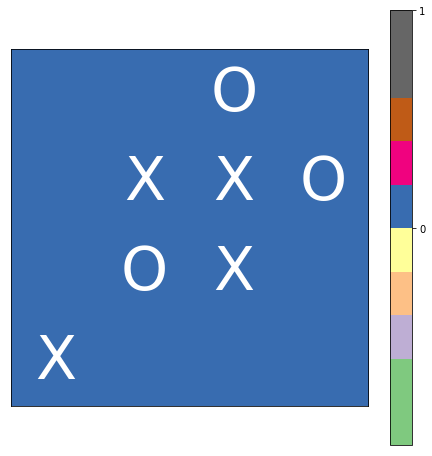

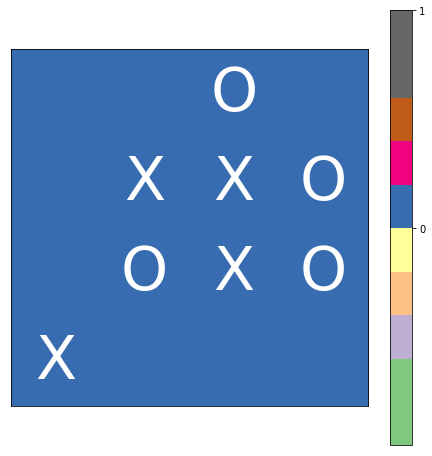

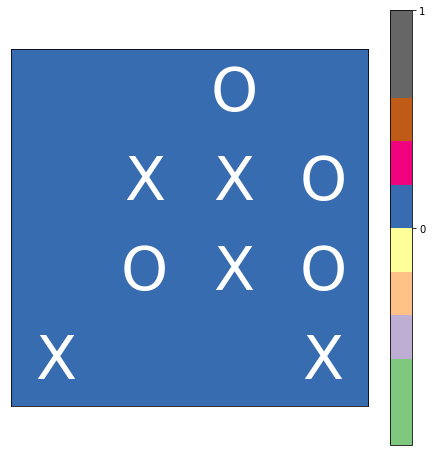

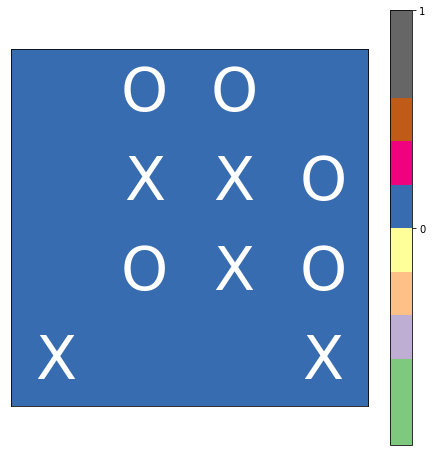

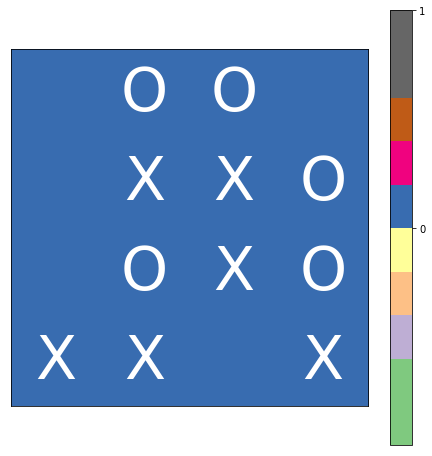

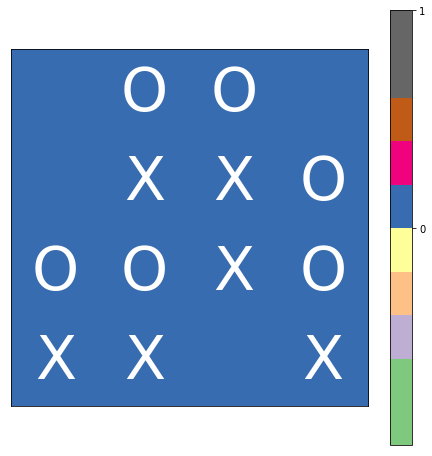

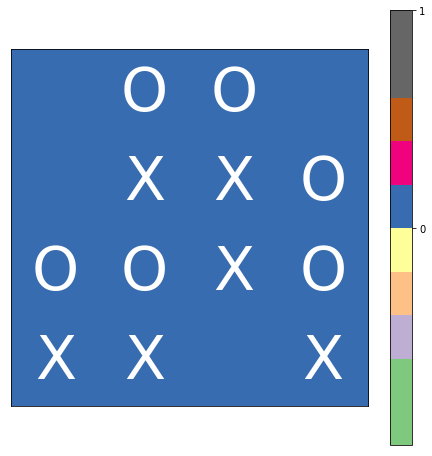

(0, 0)

In [89]:
play_game_model(env, model1, print_board=True, player1_random=False, player2_random=False)
play_game_model(env, model2, print_board=True, player1_random=False, player2_random=False)